# FedJAX Intro

[Open In Colab](https://colab.research.google.com/github/google/fedjax/blob/main/notebooks/fedjax_intro.ipynb)

This notebook introduces the basic components of FedJAX and walks through:
* What is federated learning?
* How to run federated simulations.

For more custom use cases (e.g. custom federated algorithm), please refer to [FedJAX Advanced Usages](./fedjax_advanced.ipynb).


In [ ]:
!pip install --upgrade -q fedjax==0.0.1

In [ ]:
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import fedjax

## What is federated learning?

Federated learning (FL) is "a distributed machine learning approach that trains machine learning models using decentralized examples residing on devices such as smartphones."

This means that there are two main actors in FL:
* Server: Centralized server.
* Client: Synonymous with “device”. We use the term “client” from now on.

A typical FL algorithm completes the following steps at each training round:
1. Server selects a subset of Clients to participate in training.
2. Server broadcasts model parameters to the selected Clients.
3. Clients complete training on local data.
4. Clients send model updates to the Server.
5. Server aggregates Client updates into a single update.
6. Server uses this aggregation to update the model.


## How to run federated simulations

In this section, we'll describe how to run federated learning simulations. A federated learning simulation typically consists of the following components:
* Federated dataset: a list of client ids and a dataset for each client id.
* Model and parameters
* Federated algorithm: defines how to train across clients and aggregate multiple client outputs into a single server output

We will use the [Federated EMNIST-62](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/emnist/load_data) image recognition task and train our model using the [Federated Averaging](https://arxiv.org/pdf/1602.05629.pdf) algorithm.

### Loading the dataset

For EMNIST, the examples are grouped by writer source where each writer is treated as a separate client. For more details, see https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/emnist/load_data.

FedJAX reuses the already well-defined and supported [`tff.simulation.ClientData`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/ClientData) construct introduced by TensorFlow Federated (TFF). There are quite a few functionalities baked in to `tff.simulation.ClientData`, but for the most part, we only use `client_ids` and `create_tf_dataset_for_client`.

For convenience, we provide `fedjax.datasets.emnist.load_data` as well as other canonical federated datasets under `fedjax.datasets`.

In [ ]:
federated_train, federated_test = fedjax.datasets.emnist.load_data(
    only_digits=False)

print('client_ids', federated_train.client_ids[:5])
client_id = federated_train.client_ids[0]
client_dataset = federated_train.create_tf_dataset_for_client(client_id)
print('client_dataset.element_spec', client_dataset.element_spec)

169811968/169808360 [==============================] - 4s 0us/step
client_ids ['f0000_14', 'f0001_41', 'f0005_26', 'f0006_12', 'f0008_45']
client_dataset.element_spec OrderedDict([('x', TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(), dtype=tf.int32, name=None))])


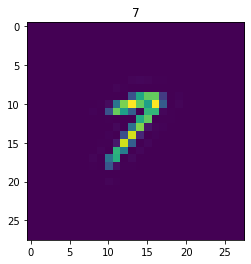

In [ ]:
examples = list(client_dataset.as_numpy_iterator())
pixels = examples[-1]['x']
label = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'[
    examples[-1]['y']]
plt.title(f'{label}')
plt.imshow(pixels.reshape(28, 28))

You'll notice that the output client dataset is a `tf.data.Dataset` of `tf.Tensor`. However, in order to use these examples with JAX, we'll need to convert this to NumPy arrays. Fortunately, TensorFlow provides `tf.data.Dataset.as_numpy_iterator()` which does exactly what we want and converts a `tf.data.Dataset` to an itertor of NumPy arrays.

FedJAX also provides a convenient `fedjax.ClientDataHParams` and `fedjax.preprocess_tf_dataset` that takes care of the basic preprocessing usually done on `tf.data.Dataset` (i.e. shuffling, repeating, batching, etc.)

In [ ]:
preprocessed = fedjax.preprocess_tf_dataset(
    client_dataset, fedjax.ClientDataHParams(batch_size=10))
batch = next(preprocessed.as_numpy_iterator())
batch['y']

array([27, 32, 30, 39,  1, 28, 27, 40, 40, 12], dtype=int32)

### Defining the model

In this section, we will cover how to intialize models suitable for use in FedJAX. Rather than reimplement core model components (layers, etc.), FedJAX uses a flexible structure that is implementation agnostic and works with multiple popular JAX neural network libraries (such as [Haiku](https://github.com/deepmind/dm-haiku) and [stax](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html)).

Similar to datasets, we provide a list of canonical models under `fedjax.models`.

In [ ]:
model = fedjax.models.emnist.create_dense_model(
    only_digits=False, hidden_units=100)

# fedjax.PRNGSequence == hk.PRNGSequence
# generator of fedjax.PRNGKey
rng = next(fedjax.PRNGSequence(0))
params = model.init_params(rng)
backward_pass_output = model.backward_pass(params, batch, rng)
metrics = model.evaluate(params, batch)

print('modules =', params.keys())
print('backward_pass_output.weight =', backward_pass_output.weight)
print('metrics[loss] =', metrics['loss'])
print('metrics[weight] =', metrics['weight'])
print('metrics[accuracy] =', metrics['accuracy'])

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


modules = KeysOnlyKeysView(['linear', 'linear_1', 'linear_2'])
backward_pass_output.weight = 10.0
metrics[loss] = 4.1264353
metrics[weight] = 10.0
metrics[accuracy] = 0.0


Now, we have a common `fedjax.Model` that can work with later FedJAX functions and utilities. This model has 3 core methods:

* `init_params`: Initializes model parameters given PRNGKey.
* `backward_pass`: Returns gradients w.r.t. model parameters as well as a few other outputs such as loss and scalar batch weight (typically batch size).
* `evaluate`: Runs model forward pass and evaluates output predictions.

### Federated algorithm

Now that we've defined the federated data and the model, we can move on to actually running the federated algorithm. FedJAX provides a `fedjax.FederatedAlgorithm` interface that defines:
* `init_state`: Initializes federated algorithm server state
* `run_one_round`: Runs one round of federated training

Typically, `fedjax.FederatedAlgorithm` will follow very closely to pseudocode found in papers proposing novel algorithms. For this section, we will use the federated averaging implementation already provided by FedJAX at `fedjax.algorithms.FedAvg`.

*We introduce `fedjax.Optimizer` here which is just a vanilla container around `optax` optimizer functions that groups them together for convenience.*

In [ ]:
client_optimizer = fedjax.get_optimizer(
    fedjax.OptimizerName.SGD, learning_rate=0.1)
server_optimizer = fedjax.get_optimizer(
    fedjax.OptimizerName.MOMENTUM, learning_rate=1.0, momentum=0.9)
hparams = fedjax.algorithms.FedAvgHParams(
    fedjax.ClientDataHParams(batch_size=10))
rng_seq = fedjax.PRNGSequence(0)
federated_averaging = fedjax.algorithms.FedAvg(federated_train, model,
                                               client_optimizer,
                                               server_optimizer, hparams,
                                               rng_seq)

# Initialize server state.
state = federated_averaging.init_state()

# Run multiple federated training rounds.
for i in range(1, 6):
  # Sample some subset of clients per training round.
  client_ids = federated_train.client_ids[:3]
  # Run one round of training.
  state = federated_averaging.run_round(state, client_ids)
  # Do any post processing or evaluation you'd like on output state.
  # evaluate(state)
  print(f'round {i}')

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


round 1
round 2
round 3
round 4
round 5


Now this isn't a very useful experiment because it's not doing any intermittent evaluation so there's no real way to see if federated training is progressing properly or not. Of course, you can write your own evaluation logic and other  auxiliary processes (like checkpointing). However, FedJAX provides a lot of these out-of-box in `fedjax.training`. For example, below, is an example of how to run the simulation with `fedjax.training.run_federated_experiment`.

In [ ]:
# Create directory for metrics, checkpoints, and other experiment artifacts.
! mkdir /tmp/.federated_experiment

# Set logging level to produce colab output.
from absl import logging
logging.set_verbosity(logging.INFO)

In [ ]:
config = fedjax.training.FederatedExperimentConfig(
    root_dir='/tmp/.federated_experiment',
    num_rounds=5,
    num_clients_per_round=3,
    checkpoint_frequency=1,
    num_checkpoints_to_keep=5,
    eval_frequency=1)
periodic_eval_fn_map = collections.OrderedDict(
    fed_test_eval=fedjax.training.ClientEvaluationFn(
        federated_test.preprocess(lambda ds: ds.batch(128)), model, config))

state = fedjax.training.run_federated_experiment(
    config, federated_averaging, periodic_eval_fn_map=periodic_eval_fn_map)

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
INFO:absl:round_num 1: client_ids = ['f1980_17', 'f3930_25', 'f1148_23']
INFO:absl:Saving state to /tmp/.federated_experiment/checkpoint_00000001.
INFO:absl:round 1 fed_test_eval: loss = 4.0371146
INFO:absl:round 1 fed_test_eval: regularizer = 0.0
INFO:absl:round 1 fed_test_eval: weight = 86.0
INFO:absl:round 1 fed_test_eval: accuracy = 0.093023255
INFO:absl:round_num 2: client_ids = ['f3913_01', 'f1346_08', 'f1408_02']
INFO:absl:Saving state to /tmp/.federated_experiment/checkpoint_00000002.
INFO:absl:round 2 fed_test_eval: loss = 3.74019
INFO:absl:round 2 fed_te

Now, we can examine the `root_dir` to see the artifacts automatically produced by `fedjax.training.run_federated_experiment`.
* Checkpoints
* TensorFlow event logs for evaluation

In [ ]:
! ls -Rl /tmp/.federated_experiment

/tmp/.federated_experiment:
total 3724
-rw-r--r-- 1 root root 759887 Dec 29 14:28 checkpoint_00000001
-rw-r--r-- 1 root root 759887 Dec 29 14:28 checkpoint_00000002
-rw-r--r-- 1 root root 759887 Dec 29 14:28 checkpoint_00000003
-rw-r--r-- 1 root root 759887 Dec 29 14:28 checkpoint_00000004
-rw-r--r-- 1 root root 759887 Dec 29 14:28 checkpoint_00000005
drwxr-xr-x 2 root root   4096 Dec 29 14:28 fed_test_eval

/tmp/.federated_experiment/fed_test_eval:
total 4
-rw-r--r-- 1 root root 1345 Dec 29 14:28 events.out.tfevents.1609252105.f86bbd0dcfcb.60.2498.v2
